In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import decode_static

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'

load neural data

In [3]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10


In [4]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]
spike_clusters = sorted[:,1]

In [5]:
behave_dict = data_preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


sorted decoding

In [6]:
sorted_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

sorted neural data shape: (230, 465, 30)


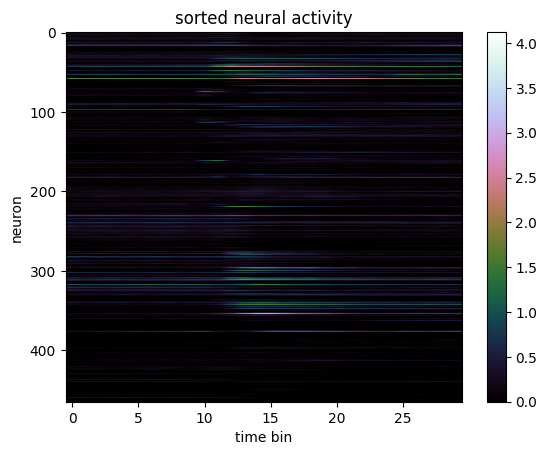

In [7]:
plt.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('sorted neural activity')
plt.xlabel('time bin')
plt.ylabel('neuron')
plt.colorbar();

In [8]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(sorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(sorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.957 auc: 0.990
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold cv accuracy: 0.033 auc: 0.007
stimulus fold 1 test accuracy: 0.413 auc: 0.818
stimulus fold 2 test accuracy: 0.543 auc: 0.884
stimulus fold 3 test accuracy: 0.587 auc: 0.850
stimulus fold 4 test accuracy: 0.457 auc: 0.846
stimulus fold 5 test accuracy: 0.587 auc: 0.903
stimulus mean of 5-fold cv accuracy: 0.517 auc: 0.860
stimulus sd of 5-fold cv accuracy: 0.071 auc: 0.030


thresholded decoding

In [9]:
thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 374, 30)


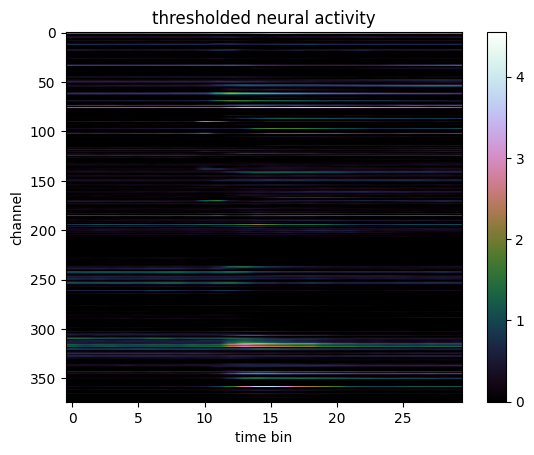

In [10]:
plt.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('thresholded neural activity')
plt.xlabel('time bin')
plt.ylabel('channel')
plt.colorbar();

In [11]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.935 auc: 0.992
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.957 auc: 0.995
choice sd of 5-fold cv accuracy: 0.031 auc: 0.006
stimulus fold 1 test accuracy: 0.391 auc: 0.802
stimulus fold 2 test accuracy: 0.522 auc: 0.869
stimulus fold 3 test accuracy: 0.565 auc: 0.835
stimulus fold 4 test accuracy: 0.413 auc: 0.837
stimulus fold 5 test accuracy: 0.543 auc: 0.882
stimulus mean of 5-fold cv accuracy: 0.487 auc: 0.845
stimulus sd of 5-fold cv accuracy: 0.071 auc: 0.028


clusterless decoding

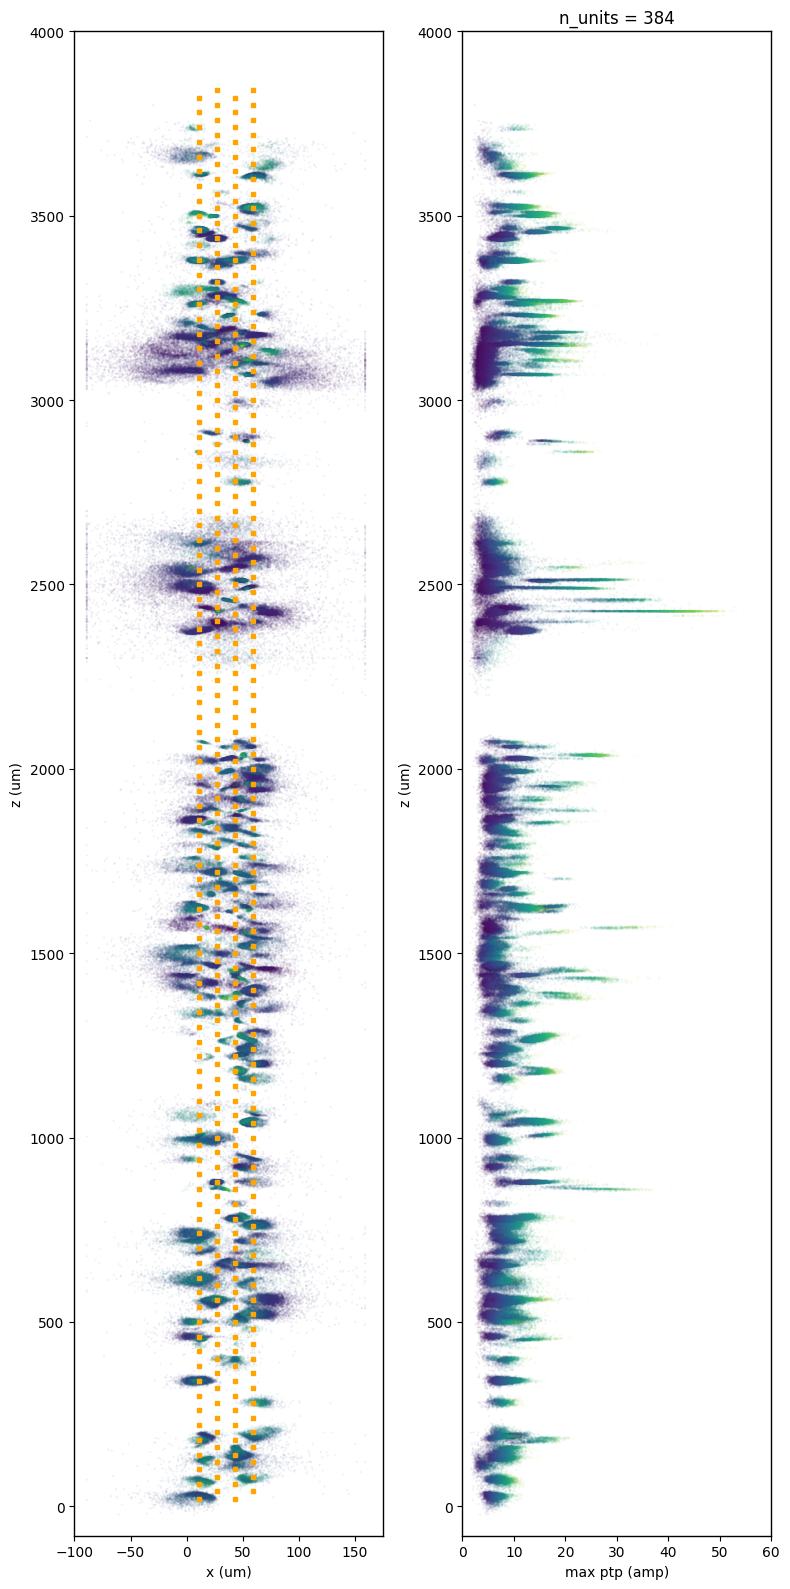

In [12]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=np.arange(n_channels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
)

model selection

In [ ]:
sample_spikes = [trial[np.random.choice(len(trial), 500), 2:] for trial in unsorted_trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

In [ ]:
lowest_bic = np.infty
bic = []
k_range = range(300, 600, 50)

for k in k_range:
    print(f'--- fit MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=0, 
        # verbose_interval=10
    )
    gmm.fit(sample_spikes)
    bic.append(gmm.bic(sample_spikes))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current bic: {round(bic[-1],2)}')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

In [ ]:
best_bic_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=400, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=1, 
        verbose_interval=1
    ).fit(spike_features)

In [ ]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(4):
    print(i*offset, (i+1)*offset)
    spike_labels.extend(best_bic_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(best_bic_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

In [ ]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='best bic MoG'
)

In [ ]:
clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

In [ ]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [ ]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

In [ ]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

In [83]:
# gmm_name = f'../pretrained/danlab/Subjects/DY_009/kilosort_localizations/best_bic_gmm'
# np.save(gmm_name + '_weights', best_bic_gmm.weights_, allow_pickle=False)
# np.save(gmm_name + '_means', best_bic_gmm.means_, allow_pickle=False)
# np.save(gmm_name + '_covariances', best_bic_gmm.covariances_, allow_pickle=False)

distributed MoG using max channel (split-merge)

In [13]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
alpha = 0.05
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    sub_x, sub_z, sub_maxptp = sub_spike_features.T
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        n_modes_x = len(UniDip(sub_x, alpha=alpha).run())
        n_modes_z = len(UniDip(sub_z, alpha=alpha).run())
        n_modes_ptp = len(UniDip(sub_maxptp, alpha=alpha).run())
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 12.0 has 3 modes ...
channel 66.0 has 2 modes ...
channel 69.0 has 4 modes ...
channel 90.0 has 3 modes ...
channel 124.0 has 6 modes ...
channel 134.0 has 4 modes ...
channel 136.0 has 3 modes ...
channel 138.0 has 2 modes ...
channel 140.0 has 4 modes ...
channel 141.0 has 4 modes ...
channel 142.0 has 4 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 3 modes ...
channel 149.0 has 3 modes ...
channel 150.0 has 2 modes ...
channel 151.0 has 2 modes ...
channel 154.0 has 3 modes ...
channel 155.0 has 3 modes ...
channel 158.0 has 4 modes ...
channel 159.0 has 2 modes ...
channel 160.0 has 4 modes ...
channel 162.0 has 2 modes ...
channel 170.0 has 2 modes ...
channel 172.0 has 2 modes ...
channel 173.0 has 2 modes ...
channel 178.0 has 4 modes ...
channel 179.0 has 2 modes ...
channel 185.0 has 5 modes ...
channel 186.0 has 5 modes ...
channel 190.0 has 3 modes ...
channel 192.0 has 3 modes ...
channel 194.0 has 2 modes ...
channel 202.0 has 3 modes ...
channel 204.0 

In [14]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [15]:
spike_features.shape

(496576, 3)

In [18]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(i*offset, (i+1)*offset)
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

0 100000
100000 200000
200000 300000
300000 400000
400000 500000


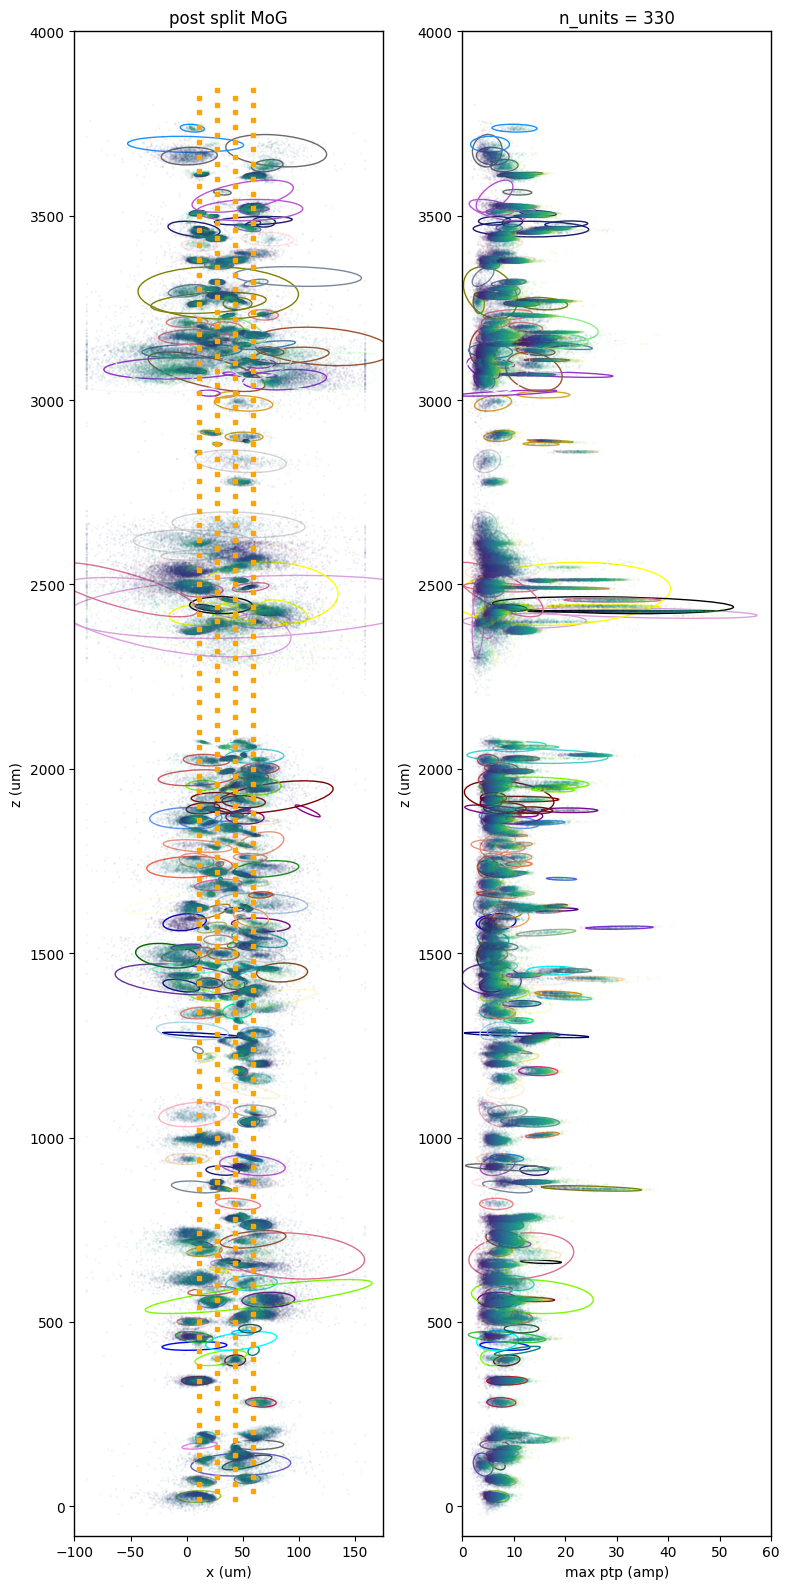

In [19]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [20]:
clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 330, 30)


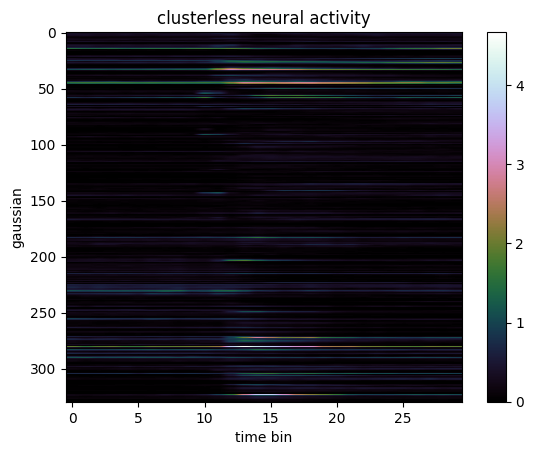

In [21]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [22]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.978 auc: 0.990
choice fold 5 test accuracy: 0.913 auc: 0.986
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold cv accuracy: 0.029 auc: 0.006
stimulus fold 1 test accuracy: 0.478 auc: 0.816
stimulus fold 2 test accuracy: 0.500 auc: 0.864
stimulus fold 3 test accuracy: 0.543 auc: 0.847
stimulus fold 4 test accuracy: 0.391 auc: 0.850
stimulus fold 5 test accuracy: 0.565 auc: 0.875
stimulus mean of 5-fold cv accuracy: 0.496 auc: 0.850
stimulus sd of 5-fold cv accuracy: 0.061 auc: 0.020


In [23]:
gmm_name = f'../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

In [25]:
del post_split_gmm
del spike_labels
del spike_probs